# Recovering gold from ore

Preparing a model that should predict the recovery rate of gold from gold-bearing ore. We have data with mining and refining parameters.

The model will help to optimize production, so as not to start the plant with unprofitable characteristics.

Plan of the project:

1. Preparing the data;
2. EDA;
3. Building and training the model.

## Preparing the data

### Discover the data

Loading necessary libraries and tools.

In [ ]:
import pandas as pd
import numpy as np
from numpy.random import RandomState
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
sns.set_palette('Dark2')

<br>
Loading data files.

In [ ]:
gold_train = pd.read_csv('/datasets/gold_recovery_train.csv', index_col='date')
gold_test = pd.read_csv('/datasets/gold_recovery_test.csv', index_col='date')
gold_full = pd.read_csv('/datasets/gold_recovery_full.csv', index_col='date')

df_list = [gold_train, gold_test, gold_full]
name_list = ['gold_train', 'gold_test', 'gold_full']

<br>
Let's see what a complete dataset looks like.

In [ ]:
gold_full.head(3)

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.

Lots of columns, which will further become features for the model.

<br>
Estimating datasets sizes.

In [ ]:
for df, name in zip(df_list, name_list):
    print(name, '-', df.shape)

gold_train - (16860, 86)
gold_test - (5856, 52)
gold_full - (22716, 86)


The number of columns in the test setis less than in the training set. For our model to be trained correctly, we further remove the necessary columns from the test set.

<br>
Analysing data types.

In [ ]:
gold_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16860 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.input.sulfate                         15553 non-null float64
primary_cleaner.input.depressant                      15598 non-null float64
primary_cleaner.i

In [ ]:
gold_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5856 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 52 columns):
primary_cleaner.input.sulfate                 5554 non-null float64
primary_cleaner.input.depressant              5572 non-null float64
primary_cleaner.input.feed_size               5856 non-null float64
primary_cleaner.input.xanthate                5690 non-null float64
primary_cleaner.state.floatbank8_a_air        5840 non-null float64
primary_cleaner.state.floatbank8_a_level      5840 non-null float64
primary_cleaner.state.floatbank8_b_air        5840 non-null float64
primary_cleaner.state.floatbank8_b_level      5840 non-null float64
primary_cleaner.state.floatbank8_c_air        5840 non-null float64
primary_cleaner.state.floatbank8_c_level      5840 non-null float64
primary_cleaner.state.floatbank8_d_air        5840 non-null float64
primary_cleaner.state.floatbank8_d_level      5840 non-null float64
rougher.input.feed_ag                         584

In [ ]:
gold_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22716 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
final.output.concentrate_ag                           22627 non-null float64
final.output.concentrate_pb                           22629 non-null float64
final.output.concentrate_sol                          22331 non-null float64
final.output.concentrate_au                           22630 non-null float64
final.output.recovery                                 20753 non-null float64
final.output.tail_ag                                  22633 non-null float64
final.output.tail_pb                                  22516 non-null float64
final.output.tail_sol                                 22445 non-null float64
final.output.tail_au                                  22635 non-null float64
primary_cleaner.input.sulfate                         21107 non-null float64
primary_cleaner.input.depressant                      21170 non-null float64
primary_cleaner.i

All data types are correct, float64. Date column will be deleted later.

<br>Check for duplicated lines.

In [ ]:
for df, name in zip(df_list, name_list):
    print(df.duplicated().sum(), 'duplicates in', name)

16 duplicates in gold_train
6 duplicates in gold_test
22 duplicates in gold_full


In [ ]:
gold_test[gold_test.duplicated()]

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-12-25 18:59:59,NaN,NaN,7.41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-12-25 19:59:59,NaN,NaN,7.41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-12-25 22:59:59,NaN,NaN,7.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-12-25 23:59:59,NaN,NaN,7.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-12-26 00:59:59,NaN,NaN,7.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-12-26 03:59:59,NaN,NaN,7.39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Duplicates were found in the files. Basically, these are missing values in the measurements made within a few hours of one day in 2016. Perhaps it was some kind of failure.

### Calculating enrichment efficiency (recovery)

Converting the formula for calculating recovery into a function.

In [ ]:
def recovery_check(c, f, t):
    return (c * (f - t)) * 100 / (f * (c - t))

In [ ]:
#C - fraction of gold in the concentrate after flotation/treatment;
#F - gold share in the feed/concentrate before flotation/treatment;
#T - fraction of gold in tailings after flotation/treatment.

gold_train['rougher.output.recovery_check'] = recovery_check(
    gold_train['rougher.output.concentrate_au'],  # C
    gold_train['rougher.input.feed_au'],  # F
    gold_train['rougher.output.tail_au'])  # T

<br>
Checking one of the parameters for omissions, before calculating the mean absolute error (MAE), 

In [ ]:
gold_train['rougher.output.recovery'].isna().sum()

2573

<br>
Calculation of MAE to calculate recovery and initial value. In the method for calculating the metric we will feed the data cleared of NaN. In the original set the parameters necessary for calculating the recovery metric contained NaN, so the column with metric calculations also contains them.

In [ ]:
recovery_mae = metrics.mean_absolute_error(gold_train.dropna()['rougher.output.recovery'],
                                           gold_train.dropna()['rougher.output.recovery_check'])
recovery_mae

1.1015161834408401e-14

The MAE tends to zero, so the recovery rate was initially calculated correctly.

### Sets analysis

As noted earlier, not all columns were included in the test set for reasons unknown to us. Our task is to bring the training and test sets to the same format with the same columns.

In [ ]:
gold_train.columns[~gold_train.columns.isin(gold_test.columns)]

Index(['final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb',
       'final.output.tail_sol', 'final.output.tail_au',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb',
       'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au',
       'rougher.calculation.sulfate_to_au_concentrate',
       'rougher.calculation.floatbank10_sulfate_to_au_feed',
       'rougher.calculation.floatbank11_sulfate_to_au_feed',
       'rougher.calculation.au_pb_ratio', 'rougher.output.concentrate_ag',
       'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol',
       'rougher.output.concentrate_au', 'rougher.outpu

<br>
The test set lacks the recovery rate for flotation and the final product, as well as many other final characteristics of each step. We also remove these columns from the train set.

In [ ]:
gold_train = gold_train[gold_test.columns]
print(f'{name_list[0]}: rows - {gold_train.shape[0]}, columns - {gold_train.shape[1]}')
print(f'{name_list[1]}: rows - {gold_test.shape[0]}, columns - {gold_test.shape[1]}')

gold_train: rows - 16860, columns - 52
gold_test: rows - 5856, columns - 52


### Data preprocessing

Evaluate the number of null values and the columns where they are present. We will not remove them at this stage, when building the model we will try different options for handling null values (including removal).

In [ ]:
(gold_train.isna().sum() * 100 / len(gold_train)).sort_values(ascending=False) # estimating the relative number of null values by column

rougher.input.floatbank11_xanthate            11.293001
primary_cleaner.input.sulfate                  7.752076
primary_cleaner.input.depressant               7.485172
rougher.input.floatbank10_sulfate              6.192171
primary_cleaner.input.xanthate                 5.842230
rougher.input.floatbank11_sulfate              3.695136
rougher.state.floatbank10_e_air                3.576512
rougher.input.feed_rate                        3.042705
rougher.input.feed_size                        2.473310
secondary_cleaner.state.floatbank2_a_air       2.153025
rougher.input.floatbank10_xanthate             2.052195
rougher.input.feed_sol                         1.731910
rougher.input.feed_pb                          1.352313
secondary_cleaner.state.floatbank2_b_air       0.919336
secondary_cleaner.state.floatbank4_a_air       0.765125
secondary_cleaner.state.floatbank3_a_level     0.670225
secondary_cleaner.state.floatbank4_a_level     0.670225
secondary_cleaner.state.floatbank2_b_level     0

Most of the missing values are present in the raw material (reagent) parameters in the flotation stage and the first purification stage.

#### Conclusion to Part 1

At this stage, we have studied the data and prepared it for further research:
- The <b>recovery</b> metric is calculated correctly;
- The index is now the date and time of the reading, so we can avoid errors when resetting the indexes;
- Columns train and test now have the same number of columns;
- No duplicated lines found;

## Data Analyse

### Tracking metal concentrations (Au, Ag, Pb)

Analyze the data using visualization and determine metal concentrations at different stages of the process.

Au Rougher mean - 17.88
Au Primary Cleaner mean - 29.21
Au Final mean - 40.0


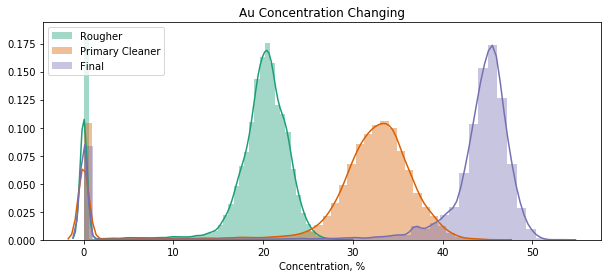


Ag Rougher mean - 10.87
Ag Primary Cleaner mean - 7.69
Ag Final mean - 4.78


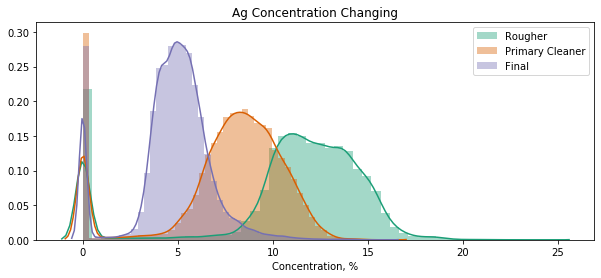


Pb Rougher mean - 6.9
Pb Primary Cleaner mean - 8.92
Pb Final mean - 9.1


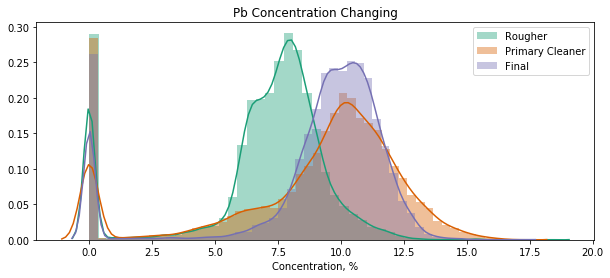

In [ ]:
metals = ['Au', 'Ag', 'Pb']
stages = ['rougher.output.concentrate_', 'primary_cleaner.output.concentrate_', 'final.output.concentrate_']
stage_names = ['Rougher', 'Primary Cleaner', 'Final']

for metal in metals:
    fig, ax = plt.subplots(figsize=(10,4))
    for stage, name in zip(stages, stage_names):
        stage = stage + metal.lower()
        fig = sns.distplot(gold_full[stage].dropna(), hist=True, label=name)
        print(metal, name, 'mean -', round(gold_full[stage].mean(), 2))
    
    ax.legend()
    ax.set(title=metal+' Concentration Changing', xlabel='Concentration, %')
    plt.show()
    print()

The metal concentrations change as follows:
- Gold increases with each step; the average metal concentration at the final purification step is 44;
- Silver decreases;
- Lead increases slightly, this may be due to the characteristics of the chemical process of flotation or the type of ore;
- Also at each stage for each metal there is about 5% of values around zero, this is more of an anomaly than a pattern.

### The size of raw material pellets on the training and test sets.

Visualization of raw material pellet size distribution (for convenience, we discard the part of the tail with large values).

Train Set:

count    16443.000000
mean        58.676444
std         23.922591
min          9.659576
25%         47.575879
50%         54.104257
75%         65.051064
max        484.967466
Name: rougher.input.feed_size, dtype: float64


Test Set:

count    5834.000000
mean       55.937535
std        22.724254
min         0.046369
25%        43.890852
50%        50.002004
75%        61.638434
max       477.445473
Name: rougher.input.feed_size, dtype: float64


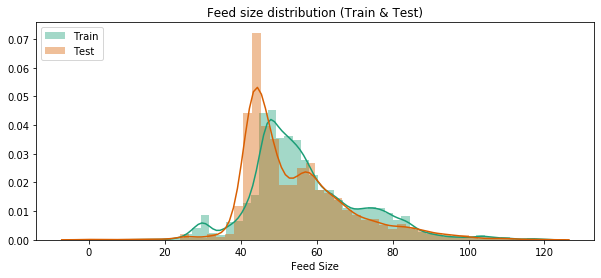

In [ ]:
fig, ax = plt.subplots(figsize=(10,4))
ax = sns.distplot(gold_train['rougher.input.feed_size'].dropna()[gold_train['rougher.input.feed_size'] < 120], 
                  label='Train')

ax = sns.distplot(gold_test['rougher.input.feed_size'].dropna()[gold_test['rougher.input.feed_size'] < 120], 
                  label='Test')

ax.legend(loc='upper left')
ax.set(title='Feed size distribution (Train & Test)', xlabel='Feed Size')

print('Train Set:\n')
print(gold_train['rougher.input.feed_size'].dropna().describe())
print('\n\nTest Set:\n')
print(gold_test['rougher.input.feed_size'].dropna().describe())

The distributions differ from each other not critically.

### Analysis of the total concentration of all substances at different stages.

Visualizing distributions to estimate the concentration of substances at different stages.

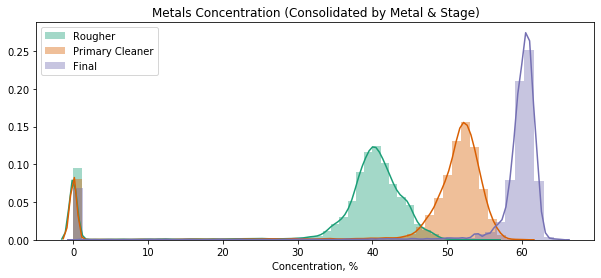

In [ ]:
stages = ['rougher.output.concentrate_', 'primary_cleaner.output.concentrate_', 'final.output.concentrate_']

fig, ax = plt.subplots(figsize=(10,4))
for stage, name in zip(stages, stage_names):
    value = (gold_full[stage + 'au'] + gold_full[stage + 'ag'] + gold_full[stage + 'pb']).dropna()
    fig = sns.distplot(value, hist=True, label=name)

ax.legend(loc='upper left')
ax.set(title='Metals Concentration (Consolidated by Metal & Stage)', xlabel='Concentration, %')
plt.show()

The concentration of metals increases predictably from stage to stage.

Null values are also found, and we will replace them with empty values.

In [ ]:
gold_full = gold_full.replace(0, np.nan)
gold_train = gold_train.replace(0, np.nan)
gold_test = gold_test.replace(0, np.nan)

#### Conclusion to Part 2

At this stage, we did 2 important things: we analyzed the specifics of the data in more detail and delved into the nuances of metal mining, as well as replaced the null values with missing values for further processing.

## Modelling

### sMAPE

Write a function for calculating the sMAPE (Symmetric Mean Absolute Percentage Error) metric and create this metric for SciKit Learn library models.

In [ ]:
def smape(X, Y):
    return (np.sum(np.abs(X - Y) / ((np.abs(X) + np.abs(Y))/2)) * 100) / len(X)

In [ ]:
smape_score = metrics.make_scorer(smape, greater_is_better=False)

### Choosing the best model

Predicting <b>rougher.output.recovery</b> it makes sense to work only with those stages that are available before receiving this data. They can be defined by columns that contain the word "rougher".

No special manipulations are required to calculate <b>final.output.recovery</b>, we will consider data from all previous stages.

In [ ]:
# Creating sets for rougher
features_train_rougher = gold_train.loc[:, gold_train.columns.str.contains('rougher')] 
target_train_rougher = gold_full.loc[features_train_rougher.index, 'rougher.output.recovery']
features_test_rougher = gold_test.loc[:, gold_test.columns.str.contains('rougher')]

# Creating sets for final
features_train_final = gold_train
target_train_final = gold_full.loc[features_train_final.index, 'final.output.recovery']
features_test_final = gold_test

<br>
Creating a pipeline of the necessary tools and set the parameters for the search.

In [ ]:
from sklearn.dummy import DummyRegressor

In [ ]:
state = RandomState(12345)

pipe = Pipeline([
    ('imp', SimpleImputer(missing_values=np.nan)),
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(n_estimators=100, random_state=state))
])

params = [
    {
        'imp__strategy':['mean', 'median', 'most_frequent'],
        'model':[RandomForestRegressor(max_depth=10)]
    }, {
        'imp__strategy': ['mean', 'median', 'most_frequent'],
        'model':[LinearRegression()]
    },{
        'imp__strategy': ['mean', 'median', 'most_frequent'],
        'model':[Lasso(random_state=state)]
    }
]

<br>
Filling in the null values in the target features, replacing them with the average.

In [ ]:
target_train_rougher = target_train_rougher.fillna(target_train_rougher.mean())
target_train_final = target_train_final.fillna(target_train_final.mean())

<br>
Seting the GridSearchCV parameters for rougher.

In [ ]:
grid_rougher = GridSearchCV(pipe, param_grid=params, cv=3, scoring=smape_score, n_jobs=-1)

In [ ]:
grid_rougher.fit(features_train_rougher, target_train_rougher)

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('imp',
                                        SimpleImputer(add_indicator=False,
                                                      copy=True,
                                                      fill_value=None,
                                                      missing_values=nan,
                                                      strategy='mean',
                                                      verbose=0)),
                                       ('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('model',
                                        RandomForestRegressor(bootstrap=True,
                                               

In [ ]:
print('Rougher:\n\nBest params:', grid_rougher.best_params_,'\nBest Score:', grid_rougher.best_score_)

Rougher:

Best params: {'imp__strategy': 'median', 'model': RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)} 
Best Score: -7.8318903123852905


The best result was shown by the Random Forest model.

<br>
Set the GridSearchCV parameters for final.

In [ ]:
grid_final = GridSearchCV(pipe, param_grid=params, cv=3, scoring=smape_score, n_jobs=-1)

In [ ]:
grid_final.fit(features_train_final, target_train_final)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('imp',
                                        SimpleImputer(add_indicator=False,
                                                      copy=True,
                                                      fill_value=None,
                                                      missing_values=nan,
                                                      strategy='mean',
                                                      verbose=0)),
                                       ('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('model',
                                        RandomForestRegressor(bootstrap=True,
                                               

In [ ]:
print('Final:\n\nBest params:', grid_final.best_params_,'\nBest Score:', grid_final.best_score_)

Final:

Best params: {'imp__strategy': 'mean', 'model': Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False,
      random_state=RandomState(MT19937) at 0x7FAEAEE8BC00, selection='cyclic',
      tol=0.0001, warm_start=False)} 
Best Score: -11.395731805142487


The best result was shown by the Lasso Regression.

<br>Calculating sMAPE using the best selected models.

In [ ]:
pipe_rougher = grid_rougher.best_estimator_

In [ ]:
pipe_rougher.fit(features_train_rougher, target_train_rougher)
target_test_rougher = pipe_rougher.predict(features_test_rougher)
smape_rougher = smape(gold_full.loc[features_test_rougher.index, 'rougher.output.recovery'], target_test_rougher)

In [ ]:
smape_rougher

4.317387551202418

In [ ]:
pipe_final = grid_final.best_estimator_

In [ ]:
pipe_final.fit(features_train_final, target_train_final)
target_test_final = pipe_final.predict(features_test_final)
smape_final = smape(gold_full.loc[features_test_final.index, 'final.output.recovery'], target_test_final)

In [ ]:
smape = 0.25*smape_rougher + 0.75*smape_final
smape

6.218953375130977

In [ ]:
smape_rougher, smape_final

(4.317387551202418, 6.85280864977383)

Dummy test for the model.

In [ ]:
rougher_median = pd.Series(target_train_rougher.median(), index=pd.Series(target_test_rougher).index)
final_median = pd.Series(target_train_final.median(), index=pd.Series(target_test_final).index)

dummy_test = (0.25*smape(target_test_rougher, rougher_median)) + (0.75*smape(target_test_final, final_median))
print(dummy_test)

In [ ]:
target_train_rougher.reset_index(drop=True)

0        87.107763
1        86.843261
2        86.842308
3        87.226430
4        86.688794
           ...    
16855    89.574376
16856    87.724007
16857    88.890579
16858    89.858126
16859    89.514960
Name: rougher.output.recovery, Length: 16860, dtype: float64

In [ ]:
def Smape(target_1, predictions):    
    a = abs(target_1 - predictions)
    b = (abs(target_1) + abs(predictions)) / 2
    errors = a / b
    return errors.sum()/ errors.shape[0] * 100

<br>
Testing the model and comparing the resulting predictions with the primitive median model.

In [ ]:
target_test_r = gold_full.loc[features_test_rougher.index, 'rougher.output.recovery'].reset_index(drop=True)
target_test_f = gold_full.loc[features_test_final.index, 'final.output.recovery'].reset_index(drop=True)

rougher_median = pd.Series(target_train_rougher.reset_index(drop=True).median(), index=target_test_r.index)
final_median = pd.Series(target_train_final.reset_index(drop=True).median(), index=target_test_f.index)

dummy_test = (0.25*Smape(target_test_r, rougher_median)) +\
             (0.75*Smape(target_test_f, final_median))
print(dummy_test)

7.0252828249449495


#### Conclusion to Part 3

We built a model and made predictions for the flotation steps. The final sMAPE metric was 6.19.